## Trabajo Pracico N3 - Performance

Objetivos:

1) Con los datos disponibles del helicóptero modelo representar la potencia reducida en función de la velocidad adimensional de vuelo (o de la relación de avance) a nivel del mar y a alturas diversas

2) Estimar la velocidad de mínima potencial y evaluar la variación con la altura

3) Estimar la velocidad de máximo alcance

4) Estimar la velocidad de descenso en autorotación en avance y la velocidad de vuelo en avance correspondiente

5) Estimar la velocidad de ascenso a nivel del mar desde punto fijo, y para $\mu = [0.1,~0.2,~0.3,~0.4,~0.5]$. Comentar por que resulta mayor a $\mu\neq 0$

6) Estimar el tiempo de punto fijo equivalente para autorotación

7) Evaluar en base a la tabla para autorotación la cualidad de la aeronave en esta actuación.

8) Comentar los resultados obtenidos en base a la comparación con los datos informados por el fabricante.

In [1]:
import sys
sys.path.append('C:\\Users\\enri\\PYTHON_PROJECTS\\Helicopteros')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import atmosfera_estandar
from scipy import interpolate
import helicopter as Helicopter
%matplotlib inline

Datos de entrada

In [3]:
gravity = 9.81 #[m/s**2]
temp = 15 + 273 # Sea level temperature
height = [0, 1000.0, 2000.0, 3000.0, 4000.0]
density = [atmosfera_estandar.atmosfera_estandar('altura',h)[4] for h in height]
temperature = [atmosfera_estandar.atmosfera_estandar('altura',h)[3] for h in height]
vel_son = [atmosfera_estandar.atmosfera_estandar('altura',h)[6] for h in height]

In [4]:
airfoil_name = 'NACA 0012'
a2d = 6 # [1/rad] airfoil Cl vs alpha slope
airfoil = Helicopter.Airfoil(name=airfoil_name, a2d=a2d)
blade_length = 7.7/2.0;
chord = 0.183 # [m]
twist = -7 * np.pi / 180.0 # [rad]
Fp = 0.97 # Blade's tip loss factor
Cd0 = 0.01035 # Mean Resistance coeficient
blade = Helicopter.Helicopter.Rotor.Blade(airfoil=airfoil, length=blade_length, chord=chord,
                               twist=twist, blade_tip_lost_factor=Fp, cd0=Cd0)
n_blades = 2
inertia_rotor = 36.4 #[kg m**2]
angular_velocity = 55.56 # [rad/s]
rotor = Helicopter.Helicopter.Rotor(blade=blade, number_of_blades=n_blades,
                         inertia=inertia_rotor, angular_velocity=angular_velocity)
weight = 590 # [kg]
helicopter = Helicopter.Helicopter(rotor=rotor, weight=weight)

In [5]:
mu = np.arange(0,0.51,0.01)#[0, 0.1, 0.2, 0.3, 0.4] # Relación de avance
velocity = [mu_val * helicopter.rotor.angular_velocity * helicopter.rotor.radius for mu_val in mu]
mu_points = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
vel_points = [mu_val * helicopter.rotor.angular_velocity * helicopter.rotor.radius for mu_val in mu_points]

vel_ind_0 = [helicopter.velocidad_inducida_0(den) for den in density]
lambda_ind_0 = [helicopter.lambda_inducido_0(den) for den in density] # Relación de flujo inducido
vel_ind = [[helicopter.velocidad_inducida(vel,den) for vel in velocity] for den in density]

## 1) calculo de la potencia reducidad

### Potencia inducida

Calculamos la potencia inducida a partir de la velocidad inducida en función de la velocidad de avance $v_{\infty}$ y la velocidad inducida en vuelo en punto fijo ${v_i}_0$, que a su ves depende de la altura $h$
.
$$v_i(v_{\infty},h)={v_i}_0(h) \cdot \sqrt{ \sqrt{ 1 + \frac{1}{4} \left(\frac{v_{\infty}}{{v_i}_0(h)}\right)^{4}} - \frac{1}{2} \left(\frac{ v_{\infty} }{ {v_i}_0(h) } \right)^{2} }$$

$${Pot}_i(v_{\infty},h) = W \cdot v_i(v_{\infty},h)$$

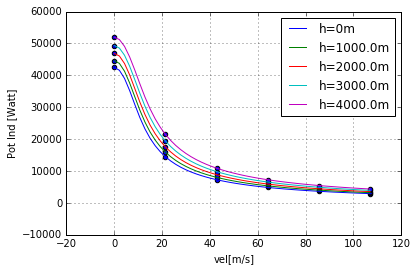

In [6]:
pot_ind = [[helicopter.potencia_inducida(vel,den) for vel in velocity] for den in density]# [Watt]
pot_ind_points = [[helicopter.potencia_inducida(vel,den) for vel in vel_points] for den in density]# [Watt]
[ plt.plot( velocity, pi, label = "h={}m".format( h ) ) for pi, h in zip( pot_ind, height ) ]
[ plt.scatter( vel_points, pi, marker='o') for pi, h in zip( pot_ind_points, height ) ]
plt.legend()
plt.ylabel("Pot Ind [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Potencia parásita de la pala

Para el calculo de la potencia parasita de la pala, usamos el coeficiente de resistencia parasita promedio $\bar{{Cd}_0}$ obtenido en el TP 1. La contribución de la velocidad de avance se modela con un termino cuadratico, adimensionalizado con la velocidad de punta de pala, y multiplicado por el 4.6.

$${Pot}_0(v_{\infty}, h) = \frac{1}{8} ~ \rho(h) ~ n_{blades} ~ c ~ \bar{{Cd}_0} ~ r ~ (\omega \cdot r)^{3} ~ \left( 1 + 4.6 ~\left( \frac{v_{\infty}}{(\omega~r)} \right)^2 \right)$$

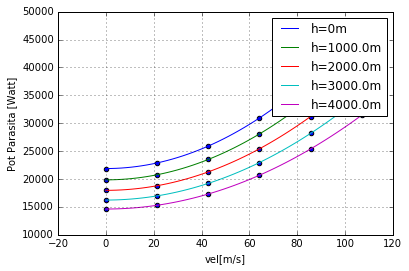

In [7]:
pot_0 = [[helicopter.potencia_parasita(vel,den) for vel in velocity] for den in density] # [Watt]
pot_0_points = [[helicopter.potencia_parasita(vel,den) for vel in vel_points] for den in density] # [Watt]

[ plt.plot( velocity, p0, label = "h={}m".format( h ) ) for p0, h in zip( pot_0, height ) ]
[ plt.scatter( vel_points, p0, marker='o') for p0, h in zip( pot_0_points, height ) ]
plt.legend()
plt.ylabel("Pot Parasita [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Potencia parásita del fuselaje y otros elementos

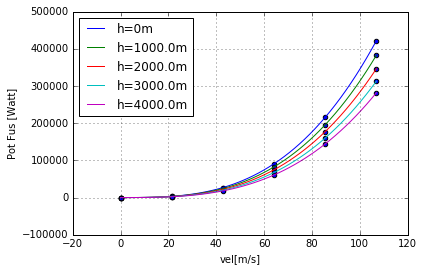

In [8]:
pot_fus = [[helicopter.potencia_fuselaje(vel,den) for vel in velocity] for den in density] # [Watt]
pot_fus_points = [[helicopter.potencia_fuselaje(vel,den) for vel in vel_points] for den in density] # [Watt]
[ plt.plot( velocity, pf, label = "h={}m".format( h ) ) for pf, h in zip( pot_fus, height ) ]
[ plt.scatter( vel_points, pf, marker='o') for pf, h in zip( pot_fus_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Pot Fus [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Potencia Necesaria

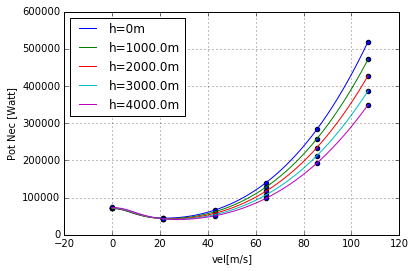

In [9]:
pot_nec = [[helicopter.potencia_necesaria(vel,den) for vel in velocity] for den in density] # [Watt]
pot_nec_points = [[helicopter.potencia_necesaria(vel,den) for vel in vel_points] for den in density] # [Watt]
[ plt.plot( velocity, pf, label = "h={}m".format( h ) ) for pf, h in zip( pot_nec, height ) ]
[ plt.scatter( vel_points, pf, marker='o') for pf, h in zip( pot_nec_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Pot Nec [Watt]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

###  Coeficiente de potencia reducida necesaria

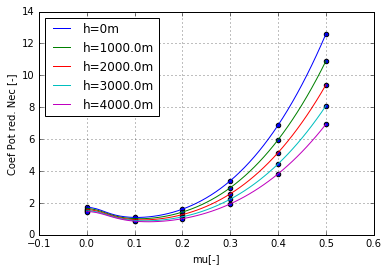

In [10]:
coef_pot_red_nec = [[helicopter.coeficiente_de_potencia_reducida_necesaria(vel,den) for vel in velocity] for den in density] # [Watt]
coef_pot_red_nec_points = [[helicopter.coeficiente_de_potencia_reducida_necesaria(vel,den) for vel in vel_points] for den in density] # [Watt]

[ plt.plot( mu, cprn, label = "h={}m".format( h ) ) for cprn, h in zip( coef_pot_red_nec, height ) ]
[ plt.scatter( mu_points, cprn, marker='o' ) for cprn, h in zip( coef_pot_red_nec_points, height ) ]
plt.legend(loc='upper left')
plt.ylabel("Coef Pot red. Nec [-]")
plt.xlabel("mu[-]")
plt.grid()
plt.show()

## 2) Velocidad de mínima potencia

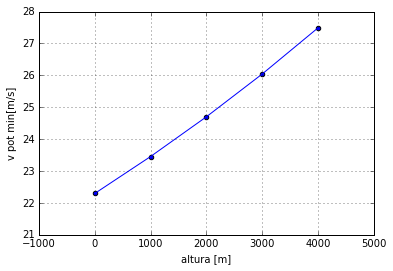

In [11]:
v_pot_min = [helicopter.velocidad_de_potencia_minima(den) for den in density]
plt.plot( height, v_pot_min )
plt.scatter( height, v_pot_min, marker='o')
plt.ylabel("v pot min[m/s]")
plt.xlabel("altura [m]")
plt.grid()
plt.show()

## 3) Velocidad de maximo alcance

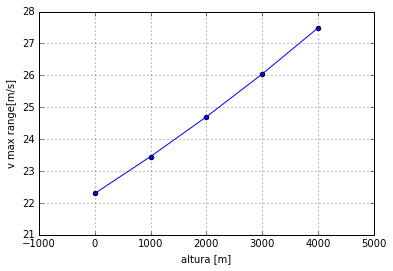

In [12]:
v_max_range = [helicopter.velocidad_de_maximo_alcance(den) for den in density]
plt.plot( height, v_pot_min )
plt.scatter( height, v_pot_min, marker='o')
plt.ylabel("v max range[m/s]")
plt.xlabel("altura [m]")
plt.grid()
plt.show()

Grafico de velocidad de potencia mínima y velocida de maximo alcance

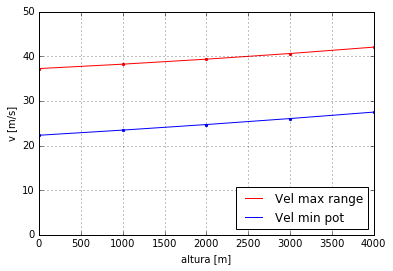

In [13]:
plt.plot( height, v_max_range, color=[1,0,0], label='Vel max range')
plt.scatter(height, v_max_range, color=[1,0,0], marker='.')
plt.plot( height, v_pot_min, color=[0,0,1], label='Vel min pot')
plt.scatter( height, v_pot_min, color=[0,0,1], marker='.')
plt.legend(loc=4)
plt.ylabel("v [m/s]")
plt.xlabel("altura [m]")
axes = plt.gca()
axes.set_xlim([height[0],height[-1]])
axes.set_ylim([0,50])
plt.grid()
plt.show()

## 4) Velocidad de descenso en autorotación

Calculamos la velocidad de descenso en autorotación en función de la velocidad de avance, para las distintas alturas estudiadas. Para esto, toda la energia potencial que pierde la aeronave en el descenso, se convierte en energia para propulsar la aeronave. Tambien se asume que esta energia es la misma que en el caso de vuelo horizontal. Por ende, la razon de disminución de energia potencial en función del timpo ($W \cdot g \cdot  v_{h_{autorot}}$) es igual a la potencia necesaria para una determinada altura y velocidad de avance $P_{nec}(V_{\infty},h)$

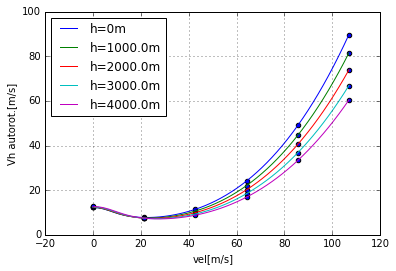

In [14]:
v_h_autorot = [[helicopter.velocidad_autorotacion(vel,den) for vel in velocity] for den in density]
v_h_autorot_points = [[helicopter.velocidad_autorotacion(vel,den) for vel in vel_points] for den in density]

[ plt.plot( velocity, vh, label = "h={}m".format( h ) ) for vh, h in zip( v_h_autorot, height ) ]
[ plt.scatter( vel_points, vh, marker='o') for vh, h in zip( v_h_autorot_points, height ) ]
plt.legend(loc=2)
plt.ylabel("Vh autorot.[m/s]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

## 5) Estimación de la velocidad de ascenso 

### Potencia Disponible

La potencia disponible de un turbomotor disminuye linealmente con la altura, segun la función:
$$Pot_{disp} = P_{h_0} \cdot \left( 1 - 0.037\left(\frac{h}{304.8}\right) \right)$$

Siendo $P_{h_0}$ la potencia máxima del motor. Este helicóptero posee un motor Lycoming HIO-360-D1A con una potencia máxima de 131 HP (97.7 Kw). La potencia disponible para la planta motriz en función de la altura disminuye un 3.7%/K.ft


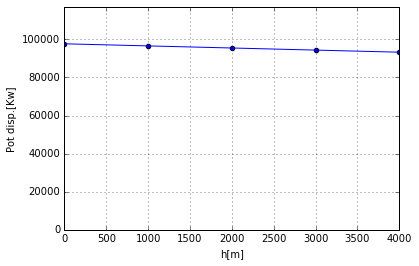

In [15]:
pot_h_0 = 131 * 745.6998715822701 # [watt]
engine_manufacturer = Helicopter.EngineType.LYCOMING
helicopter.engine = Helicopter.Helicopter.Engine(engine_type=engine_manufacturer,
                                                potencia_maxima=pot_h_0)
pot_disp = [helicopter.engine.potencia_disponible(h) for h in height]
plt.plot(height, pot_disp)
plt.scatter(height, pot_disp, marker='o')
plt.axis([height[0], height[-1], 0, 1.2*pot_disp[0]])
plt.ylabel("Pot disp.[Kw]")
plt.xlabel("h[m]")
plt.grid()
plt.show()

### Potencia disponible vs potencia necesaria

Graficamos la potencial disponible y necesaria para cada altura

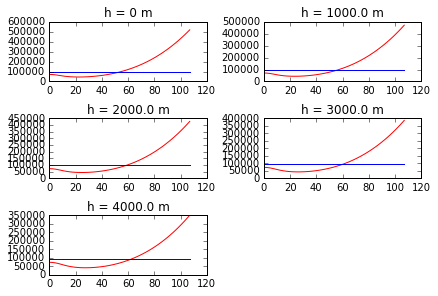

In [16]:
plt.subplot(3, 2, 1)
plt.plot(velocity, pot_nec[0], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[0]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[0]))
plt.subplot(3, 2, 2)
plt.plot(velocity,  pot_nec[1], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[1]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[1]))
plt.subplot(3, 2, 3)
plt.plot(velocity,  pot_nec[2], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[2]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[2]))
plt.subplot(3, 2, 4)
plt.plot(velocity,  pot_nec[3], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[3]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[3]))
plt.subplot(3, 2, 5)
plt.plot(velocity,  pot_nec[4], label='Pot. nec.',color=[1,0,0])
plt.plot(velocity, pot_disp[4]*np.ones(len(velocity)), label='Pot. disp.', color=[0,0,1])
plt.title('h = {} m'.format(height[4]))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

Calculamos el excedente de pontencia para cada caso: $$\Delta Pot = {Pot}_{disp} - {Pot}_{nec}$$

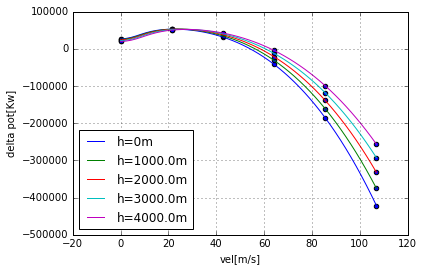

In [17]:
delta_pot = [[helicopter.potencia_excedente(vel, h) for vel in velocity] for h in height]
delta_pot_points = [[helicopter.potencia_excedente(vel, h) for vel in vel_points] for h in height]
[ plt.plot( velocity, dp, label="h={}m".format( h ) ) for dp, h in zip( delta_pot, height ) ]
[ plt.scatter( vel_points, dp, marker='o' ) for dp in delta_pot_points]
plt.legend(loc=3)
plt.ylabel("delta pot[Kw]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

###  Tracción necesaria

La tracción producida por el rotor debe ser tal que debe vencer tanto el peso 
de la aeronave, como la resistencia (solo consideramos la del fuselaje).
$$ T = \sqrt{W_{max}^2 + D_f^2}$$
Donde: $D_f = 0.5~f~\rho~v^2$


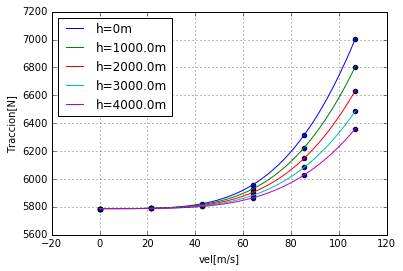

In [18]:
traccion_nec = [ [ helicopter.traccion_necesaria(vel, den) for vel in velocity] for den in density]
traccion_nec_points = [ [ helicopter.traccion_necesaria(vel, den) for vel in vel_points] for den in density]
[ plt.plot( velocity, tr, label="h={}m".format( h ) ) for tr, h in zip( traccion_nec, height ) ]
[ plt.scatter( vel_points, tr, marker='o' ) for tr in traccion_nec_points]
plt.legend(loc=2)
plt.ylabel("Traccion[N]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Velocidad de Ascenso

Calculamos la velocidad de ascenso a partir de $\Delta Pot$, la tracción $T$, y la velocidad inducida en punto fijo ${V_i}_0$

$$ V_{asc} = \frac{\Delta P}{T} \cdot \frac{2 {V_i}_0 + \frac{\Delta P}{T}}{{V_i}_0 + \frac{\Delta P}{T}} $$

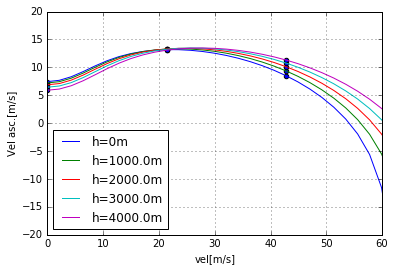

In [19]:
v_asc = [ [ helicopter.velocidad_de_ascenso(vel, h) for vel in velocity] for h in height]
v_asc_points = [ [ helicopter.velocidad_de_ascenso(vel, h) for vel in vel_points] for h in height]
[ plt.plot( velocity, va, label="h={}m".format( h ) ) for va, h in zip( v_asc, height ) ]
[ plt.scatter( vel_points, va, marker='o' ) for va in v_asc_points]
plt.axis([0,60,-20,20])
plt.legend(loc=0)
plt.ylabel("Vel asc.[m/s]")
plt.xlabel("vel[m/s]")
plt.grid()
plt.show()

### Techo practico

Definimos techo práctico como la altura para la cual la velocidad de ascenso es de $0.5~m/s$

c:\users\enri\appdata\local\programs\python\python35-32\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
c:\users\enri\appdata\local\programs\python\python35-32\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


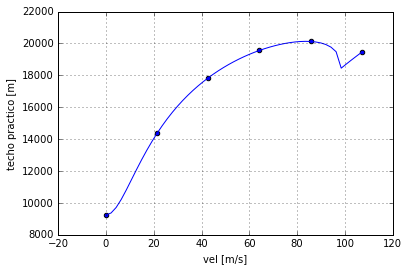

In [36]:
techo_practico = [helicopter.techo_practico(vel, h_guess=30000) for vel in velocity]
techo_practico_points = [helicopter.techo_practico(vel, h_guess=30000) for vel in vel_points]
plt.plot(velocity, techo_practico)
plt.scatter(vel_points, techo_practico_points)
plt.ylabel("techo practico [m]")
plt.xlabel("vel [m/s]")
plt.grid()
plt.show()

In [47]:
print("Techo practico vuelo en punto fijo: {:.1f} m".format(float(techo_practico[0])))
print("Techo practico maximo: {:.1f} m".format(float(max(techo_practico))))
print("Velocidad de avance para techo maximo: {:.2f} m/s".format(velocity[techo_practico.index(max(techo_practico))]))


Techo practico vuelo en punto fijo: 9243.1 m
Techo practico maximo: 20134.3 m
Velocidad de avance para techo maximo: 83.42 m/s


El techo practico en vuelo en punto fijo es de {{techo_practico[0]}} m, mientras que el techo practico maximo es de {{max(techo_practico)}} m, para una velocidad de avance de {{vel[techo_practico.index(max(techo_practico))]}} m/s.
    
La expresión dada para la potencia reducida subestima la potencia necesaria para el vuelo del helicóptero a velocidad de avance creciente por no tener en cuenta la perdida de sustentación en la pala retrocederte y el incremento de resistencia aerodinámica por efecto de compresibilidad del aire en la pala que avanza.

## 6) Estimacion el tiempo de punto fijo equivalente para autorotación

## 7) Calidad de la autorotación en vase al tiempo de punto fijo equivalente

## 8) Comentar los resultados obtenidos en base a la comparación con los datos informados por el fabricante.

### Potencia adicional para el accionamiento del motor anticupla

Se considera de manera semejante como en el caso de vuelo a punto fijo. Se podría proceder haciendo una evaluación completa del rotor anticupla , o bien adoptar un cierto valor porcentual de la potencia suministrada al rotor principal ; en este caso se asume un 10% en lugar del 12% considerado en punto fijo , es decir:

$$ P_{{nec}_{a.c}} = 1.1 \cdot P_{nec}$$

In [ ]:
pot_nec_ac = [[ 1.1*p for p in p_nec] for p_nec in pot_nec]
plt.subplot(3, 2, 1)
plt.plot(vel, pot_nec[0], label='Pot. nec.',color=[1,0,0])
plt.plot(vel, pot_nec_ac[0], label='Pot. nec. ac.', color=[0,0,1])
plt.title('h = {} m'.format(height[0]))
plt.subplot(3, 2, 2)
plt.plot(vel,  pot_nec[1], label='Pot. nec.',color=[1,0,0])
plt.plot(vel, pot_nec_ac[1], label='Pot. nec. ac.', color=[0,0,1])
plt.title('h = {} m'.format(height[1]))
plt.subplot(3, 2, 3)
plt.plot(vel,  pot_nec[2], label='Pot. nec.',color=[1,0,0])
plt.plot(vel, pot_nec_ac[2], label='Pot. nec. ac.', color=[0,0,1])
plt.title('h = {} m'.format(height[2]))
plt.subplot(3, 2, 4)
plt.plot(vel,  pot_nec[3], label='Pot. nec.',color=[1,0,0])
plt.plot(vel, pot_nec_ac[3], label='Pot. nec. ac.', color=[0,0,1])
plt.title('h = {} m'.format(height[3]))
plt.subplot(3, 2, 5)
plt.plot(vel,  pot_nec[4], label='Pot. nec.',color=[1,0,0])
plt.plot(vel, pot_nec_ac[4], label='Pot. nec. ac.', color=[0,0,1])
plt.title('h = {} m'.format(height[4]))
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()

### Correción de la potencia necesaria por efecto de la pérdida aerodinámica en la pala que retrocede

A medida que la velocidad de avance del helicoptero aumenta, la velocidad local en la pala que retrocede ($\Psi=270^o$) se reduce, y, por ende, el ángulo de ataque local debe aumentar para compensar este deficit de velocidad y mantener la tracción constante. Cuando el ángulo de ataque del elemento de pala supera el angulo de pérdida del perfil, la capa límite se desprende del perfil, y se produce una disminución de la tracción y un aumento de la resistencia. Para evaluar el aumento de la resistencia, calculamos la región del rotor donde $\alpha(r,\Psi)>\alpha_{pérdida}$.

In [ ]:
alpha_perdida = 9*np.pi/180.0
CT0_solidity_fun = lambda den        : weight/(area_blades * den * (radius_rotor*angular_velocity)**2)
CT0_fun          = lambda den        : CT0_solidity_fun(den) *solidity
CT_fun           = lambda den, mu_vel: CT0_fun(den) * np.sqrt(1 + ( f * mu_vel**2 / 2 / area_blades / CT0_solidity_fun(den) ) )
alpha_PTP_fun    = lambda den, mu_vel: f*mu_vel**2 / (2*area_blades*CT_fun(den, mu_vel))
lamda_ind        = lambda den, mu_vel: np.sqrt( 0.5 * (np.sqrt(CT_fun(den, mu_vel)**2 + mu_vel**4) - mu_vel**2) )
lambda_pasante   = lambda den, mu_vel: mu_vel * alpha_PTP(den, mu_vel) - lambda_ind(den, mu_vel)
theta_0          = lambda den, mu_vel:(  (12/a2d * (Fp**2/3 + mu_vel**2/2) * CT_fun(mu_vel,den)/solidity
                                          - Fp**2 / 2 * (Fp**4 + 3/2 * mu_vel**2 * (mu_vel**2 - Fp**2)) * twist
                                          - (Fp**4 - mu_vel**2/2) * lambda_pasante(mu_vel, den))
                                        / (Fp * (2/3*Fp**4 - 3/2*mu_vel**2*Fp**2 + 3/2*mu_vel**4) ) )
theta_34         = lambda den, mu_vel: theta_0(den, mu_vel) + 3/4 * twist
aleteo_long      = lambda den, mu_vel: (mu_vel * (8/3*Fp*theta_0(den, mu_vel) + 2*Fp**2*twist + 2*lambda_pasante(den,mu_vel))
                                        / (Fp**2 + 3/2 * mu_vel**2))
alpha_tip_90     = lambda den, mu_vel: ( 1/(1+mu_vel) * (theta_0(den, mu_vel) 
                                                        + twist
                                                        - aleteo_long(den, mu_vel) 
                                                        - lambda_ind(den, mu_vel) 
                                                        + mu_vel * (alpha_PTP(den, mu_vel)
                                                                    + theta_0(den, mu_vel)
                                                                    + twist
                                                                    - aleteo_long(den, mu_vel) )))


In [ ]:
alpha_perdida = 9*np.pi/180.0
Ct0_solidity = [weight/(area_blades * den * (radius_rotor*angular_velocity)**2) for den in density]
Ct0 = [ct*solidity for ct in Ct0_solidity]
Ct = [[ct0 * np.sqrt(1 + ( solidity * f * mu_vel**2 / 2 / area_blades / ct0 ) )  for mu_vel in mu] for ct0 in Ct0]
alpha_PTP = [[f*mu_vel**2 / (2*area_blades*ct0) for mu_vel in mu] for ct0 in Ct0_solidity]
lambda_ind = [[np.sqrt( 0.5 * (np.sqrt(ct**2 + mu_vel**2) - mu_vel**2) ) for ct,mu_vel in zip(ct_var,mu)] for ct_var in Ct]
lambda_pasante = [[mu_vel * alpha - lambda_i for mu_vel,alpha,lambda_i in zip(mu,alpha_aux, lambda_i_aux)] for alpha_aux, lambda_i_aux in zip(alpha_PTP,lambda_ind)]
ang_paso_colectivo = []

### Correción de la potencia necesaria por efecto de compresibilidad del aire sobre la pala que avanza.

El aumento de potencia necesaria for efecto de la compresibilidad en la para que avan